## Imports and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.utils import resample
import scipy
from numpy.fft import fft
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.feature_selection import SelectKBest, chi2
from tsfresh.transformers import FeatureSelector
np.random.seed(8055)

C:\Users\owner\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# load data
hr = pd.read_csv('../data/alpaca_hr.csv')
resp = pd.read_csv('../data/alpaca_resp.csv')
sao2 = pd.read_csv('../data/alpaca_sao2.csv')

hr['offset'] = hr['offset'] / 60
resp['offset'] = resp['offset'] / 60
sao2['offset'] = sao2['offset'] / 60

gcs = pd.read_csv('../data/patient_motor.csv')
gcs = gcs[gcs['observationoffset'] > -1]
gcs['observationoffset'] = gcs['observationoffset'] / 60
final_gcs_id = gcs.groupby('patientunitstayid')['observationoffset'].transform(max) == gcs['observationoffset']

final_gcs = gcs[final_gcs_id]
display(final_gcs['Value'].isna().sum())

#display(hr)
#display(resp)
#display(sao2)

0

In [3]:
print(final_gcs)

        patientunitstayid  observationoffset    Key  Value          origin
0                  172448           2.500000  Motor    1.0  nurse_charting
31                 242714          46.850000  Motor    6.0  nurse_charting
40                 242825          12.733333  Motor    6.0  nurse_charting
45                 243176          54.566667  Motor    6.0  nurse_charting
86                 243493          59.033333  Motor    6.0  nurse_charting
...                   ...                ...    ...    ...             ...
135846            3351268         187.383333  Motor    6.0  nurse_charting
135847            3351533          29.583333  Motor    6.0  nurse_charting
135858            3351909         156.950000  Motor    6.0  nurse_charting
135900            3352618         346.600000  Motor    6.0  nurse_charting
135907            3352819          89.616667  Motor    6.0  nurse_charting

[2608 rows x 5 columns]


# Lab Data

In [184]:
lab_data = pd.read_csv('../data/lab_data.csv')
lab_data_piv = pd.pivot_table(lab_data, index=['patientunitstayid',
    'labresultoffset'], columns='labname', values = 'labresult').reset_index()
lab_data_piv = lab_data_piv.drop(columns=['labresultoffset'])

# get counts of each lab for each patient
lab_cts = lab_data_piv.groupby('patientunitstayid').count().reset_index()

# get avg lab value for each patient
lab_avgs = lab_data_piv.groupby('patientunitstayid').mean().reset_index()

In [213]:
lab_indicator = pd.DataFrame()
lab_indicator['patientunitstayid'] = lab_cts['patientunitstayid']
for col in lab_cts.columns:
    if col != 'patientunitstayid':
        data = list(lab_cts[col])
        data = [1 if d > 0 else 0 for d in data]
        lab_indicator[col] = data

# Finding labs with at least 90% patients
geq90 = lab_indicator[lab_indicator.columns[lab_indicator.mean() >= 0.9]]
all_labs_geq90 = geq90[(geq90.T != 0).all()]
patients_all_geq90 = all_labs_geq90['patientunitstayid']
geq20 = lab_indicator[lab_indicator.columns[lab_indicator.mean() >= 0.2]]

print(patients_all_geq90.shape)
print(patients_all_geq90.drop_duplicates().shape)
print(geq20.shape)
print(lab_cts.shape)
print(lab_indicator.shape)
print(geq90.shape)
print(all_labs_geq90.shape)
display(all_labs_geq90)
print(all_labs_geq90.columns[1:])

(4484,)
(4484,)
(5334, 47)
(5334, 142)
(5334, 142)
(5334, 17)
(4484, 17)


,patientunitstayid,BUN,Hct,Hgb,MCHC,MCV,RBC,RDW,WBC x 1000,bicarbonate,calcium,chloride,creatinine,glucose,platelets x 1000,potassium,sodium
0,143094,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,143103,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,143274,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,144116,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,145396,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5329,3352294,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5330,3352295,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5331,3352531,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5332,3352618,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Index(['BUN', 'Hct', 'Hgb', 'MCHC', 'MCV', 'RBC', 'RDW', 'WBC x 1000',
       'bicarbonate', 'calcium', 'chloride', 'creatinine', 'glucose',
       'platelets x 1000', 'potassium', 'sodium'],
      dtype='object')


In [4]:
# Loading lab data
lab = pd.read_csv('../data/lab_data.csv')
lab = lab.loc[lab['labresultoffset'] > -1]
lab = lab.loc[lab['labresultoffset'] <= 24*60]
display(lab)
labtypes = list(lab['labname'].drop_duplicates())

,Unnamed: 0,patientunitstayid,diagnosisstring,labid,patientunitstayid.1,labresultoffset,labtypeid,labname,labresult,labresulttext,labmeasurenamesystem,labmeasurenameinterface,labresultrevisedoffset
14,14,976143,burns/trauma|trauma - CNS|spinal cord injury|c...,231365792,976143,1259,4.0,bedside glucose,106.00,106,mg/dL,mg/dL,1259
82,82,2896749,neurologic|trauma - CNS|intracranial injury,653612385,2896749,534,3.0,PTT,31.40,31.4,sec,sec,534
87,87,2896749,neurologic|trauma - CNS|intracranial injury,669448807,2896749,534,3.0,Hct,36.70,36.7,%,%,534
107,107,2896749,neurologic|trauma - CNS|intracranial injury,648051805,2896749,1059,2.0,Vancomycin - trough,16.70,16.7,mcg/mL,ug/mL,1059
131,131,2896749,neurologic|trauma - CNS|intracranial injury,648754398,2896749,534,3.0,PT,14.60,14.6,sec,sec,534
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374604,374604,962326,neurologic|trauma - CNS|intracranial injury|wi...,228891620,962326,294,1.0,total protein,5.10,5.1,g/dL,g/dL,342
2374608,374608,962326,neurologic|trauma - CNS|intracranial injury|wi...,228891619,962326,294,1.0,bicarbonate,23.00,23,mmol/L,mmol/L,342
2374610,374610,962326,neurologic|trauma - CNS|intracranial injury|wi...,228891613,962326,294,1.0,alkaline phos.,60.00,60,Units/L,IU/L,342
2374612,374612,962326,neurologic|trauma - CNS|intracranial injury|wi...,228891612,962326,294,1.0,creatinine,1.25,1.250,mg/dL,mg/dL,342


In [5]:
# Getting table of averages over first 24 hours
l = labtypes[0]
labtypedata = lab[lab['labname'] == l]
labtypedata_avgs = labtypedata.groupby('patientunitstayid').mean()['labresult']
labtypedata_avgs = labtypedata_avgs.to_frame()
labtypedata_avgs = labtypedata_avgs.reset_index()
labtypedata_avgs =labtypedata_avgs.rename(columns = {'labresult':l})
for l in labtypes[1:]:
    labtypedata = lab[lab['labname'] == l]
    labtypedata_avgs1 = labtypedata.groupby('patientunitstayid').mean()['labresult']
    labtypedata_avgs1 = labtypedata_avgs1.to_frame()
    labtypedata_avgs1 = labtypedata_avgs1.reset_index()
    labtypedata_avgs1 =labtypedata_avgs1.rename(columns = {'labresult':l})
    labtypedata_avgs = labtypedata_avgs.merge(labtypedata_avgs1, how='outer', on='patientunitstayid')

In [6]:
labtypedata_avgs = labtypedata_avgs[labtypedata_avgs.columns[labtypedata_avgs.isnull().mean() < 0.2]]
#labtypedata_avgs.head()

In [7]:
lab_avgs_map = {}
for l in labtypes:
    if l in labtypedata_avgs.columns:
        col = list(labtypedata_avgs[l].dropna())
        if len(col) != 0:
            avg = sum(col)/len(col)
            lab_avgs_map[l] = avg
        else:
            labtypedata_avgs = labtypedata_avgs.drop(columns=l)
# print(lab_avgs_map)

In [8]:
# Filling in na values for labtypedata_avgs.columns with averages
# for that column
for l in labtypedata_avgs.columns:
    if l != 'patientunitstayid':
        col = labtypedata_avgs[l]
        labtypedata_avgs[l] = col.fillna(lab_avgs_map[l])
#labtypedata_avgs.head()

In [9]:
# Getting table of measurement counts over first 24 hours
l = labtypes[0]
labtypedata = lab[lab['labname'] == l]
labtypedata_cts = labtypedata.groupby('patientunitstayid').count()['labresult']
labtypedata_cts = labtypedata_cts.to_frame()
labtypedata_cts = labtypedata_cts.reset_index()
labtypedata_cts =labtypedata_cts.rename(columns = {'labresult':l})
for l in labtypes[1:]:
    labtypedata = lab[lab['labname'] == l]
    labtypedata_cts1 = labtypedata.groupby('patientunitstayid').count()['labresult']
    labtypedata_cts1 = labtypedata_cts1.to_frame()
    labtypedata_cts1 = labtypedata_cts1.reset_index()
    labtypedata_cts1 =labtypedata_cts1.rename(columns = {'labresult':l})
    labtypedata_cts = labtypedata_cts.merge(labtypedata_cts1, how='outer', on='patientunitstayid')

In [10]:
labtypedata_cts = labtypedata_cts[labtypedata_cts.columns[labtypedata_cts.isnull().mean() < 0.2]]
labtypedata_cts = labtypedata_cts.apply(lambda x: x.fillna(x.median()),axis=0)

In [11]:
#print(labtypedata_cts.median())
labtypedata_cts = labtypedata_cts > labtypedata_cts.median()
#labtypedata_cts.head(20)

# Demographic Data

In [12]:
# Loading demographic data
demographic_all = pd.read_csv('../data/patient_demographics_data.csv')

#demographic_all.head()

died = demographic_all.loc[:, ['patientunitstayid', 'unitdischargestatus']]
died['alive'] = died['unitdischargestatus'] == 'Alive'
died = died.drop_duplicates()
display(died)

,patientunitstayid,unitdischargestatus,alive
0,2896749,Alive,True
1,976143,Alive,True
2,1823818,Alive,True
3,2715079,Alive,True
4,1015921,Alive,True
...,...,...,...
9405,2263791,Alive,True
9406,174499,Alive,True
9407,1480007,Alive,True
9408,962326,Alive,True


In [13]:
demographic_all.head()

,Unnamed: 0,patientunitstayid,diagnosisstring,patientunitstayid.1,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,0,2896749,neurologic|trauma - CNS|intracranial injury,2896749,2350019,Male,29,NaN,397,971,...,Emergency Department,1,admit,70.00,NaN,07:34:00,10378,Floor,Alive,027-95634
1,1,976143,burns/trauma|trauma - CNS|spinal cord injury|c...,976143,719568,Female,35,African American,181,428,...,Emergency Department,1,admit,77.10,84.1,18:24:00,2273,Telemetry,Alive,007-505
2,2,1823818,burns/trauma|trauma - CNS|intracranial injury|...,1823818,1435627,Male,85,Caucasian,281,687,...,Direct Admit,1,admit,84.40,84.4,18:13:00,2552,Floor,Alive,018-23662
3,3,2715079,neurologic|trauma - CNS|intracranial injury|wi...,2715079,2181711,Male,72,Caucasian,388,962,...,Emergency Department,1,admit,71.66,NaN,00:53:00,6003,Other External,Alive,027-103254
4,4,1015921,neurologic|trauma - CNS|intracranial injury|wi...,1015921,750929,Female,> 89,Caucasian,188,451,...,Other Hospital,1,admit,60.90,60.9,16:12:00,4907,Skilled Nursing Facility,Alive,008-35721


In [14]:
#for col in demographic_all.columns:
#    print(col)

# Keeping the following columns (numerical for now):
to_keep=['patientunitstayid', 'gender', 'age', 'ethnicity', 'admissionheight', 'admissionweight']
# to_keep=['age', 'admissionheight', 'admissionweight', 'patientunitstayid']
demographic = demographic_all[to_keep]
#demographic.head()
#print(demographic.dtypes)

In [15]:
demographic = demographic.replace('> 89', 90)
#demographic.head()

In [16]:
genders = list(demographic['gender'])
male = []
female = []
other = []
for g in genders:
    if g == 'Male':
        male.append(1)
        female.append(0)
        other.append(0)
    elif g == 'Female':
        male.append(0)
        female.append(1)
        other.append(0)
    else:
        male.append(0)
        female.append(0)
        other.append(1)
demographic['Male'] = male
demographic['Female'] = female
demographic['Other_Gender'] = other
demographic.head()

,patientunitstayid,gender,age,ethnicity,admissionheight,admissionweight,Male,Female,Other_Gender
0,2896749,Male,29,NaN,172.7,70.00,1,0,0
1,976143,Female,35,African American,157.5,77.10,0,1,0
2,1823818,Male,85,Caucasian,182.8,84.40,1,0,0
3,2715079,Male,72,Caucasian,177.8,71.66,1,0,0
4,1015921,Female,90,Caucasian,162.5,60.90,0,1,0


In [17]:
ethnicities = list(demographic['ethnicity'])
af_am = []
cauc = []
other = []
hisp = []
asian = []
nat_am = []
for e in ethnicities:
    if e == 'African American':
        af_am.append(1)
        cauc.append(0)
        hisp.append(0)
        asian.append(0)
        nat_am.append(0)
        other.append(0)
    elif e == 'Caucasian':
        af_am.append(0)
        cauc.append(1)
        hisp.append(0)
        asian.append(0)
        nat_am.append(0)
        other.append(0)
    elif e == 'Hispanic':
        af_am.append(0)
        cauc.append(0)
        hisp.append(1)
        asian.append(0)
        nat_am.append(0)
        other.append(0)
    elif e == 'Asian':
        af_am.append(0)
        cauc.append(0)
        hisp.append(0)
        asian.append(1)
        nat_am.append(0)
        other.append(0)
    elif e == 'Native American':
        af_am.append(0)
        cauc.append(0)
        hisp.append(0)
        asian.append(0)
        nat_am.append(1)
        other.append(0)
    else:
        af_am.append(0)
        cauc.append(0)
        hisp.append(0)
        asian.append(0)
        nat_am.append(0)
        other.append(1)
demographic['af_am'] = af_am
demographic['caucasian'] = cauc
demographic['hisp'] = hisp
demographic['asian'] = asian
demographic['nat_am'] = nat_am
demographic['other_nat'] = other
demographic.head()

,patientunitstayid,gender,age,ethnicity,admissionheight,admissionweight,Male,Female,Other_Gender,af_am,caucasian,hisp,asian,nat_am,other_nat
0,2896749,Male,29,NaN,172.7,70.00,1,0,0,0,0,0,0,0,1
1,976143,Female,35,African American,157.5,77.10,0,1,0,1,0,0,0,0,0
2,1823818,Male,85,Caucasian,182.8,84.40,1,0,0,0,1,0,0,0,0
3,2715079,Male,72,Caucasian,177.8,71.66,1,0,0,0,1,0,0,0,0
4,1015921,Female,90,Caucasian,162.5,60.90,0,1,0,0,1,0,0,0,0


In [18]:
demographic = demographic.drop(columns = ['gender', 'ethnicity'])
demographic.head()

,patientunitstayid,age,admissionheight,admissionweight,Male,Female,Other_Gender,af_am,caucasian,hisp,asian,nat_am,other_nat
0,2896749,29,172.7,70.00,1,0,0,0,0,0,0,0,1
1,976143,35,157.5,77.10,0,1,0,1,0,0,0,0,0
2,1823818,85,182.8,84.40,1,0,0,0,1,0,0,0,0
3,2715079,72,177.8,71.66,1,0,0,0,1,0,0,0,0
4,1015921,90,162.5,60.90,0,1,0,0,1,0,0,0,0


In [19]:
demographic = demographic.astype(float)
print(demographic.shape)

(9410, 13)


In [20]:
#print(hr['value'].isna().sum())

In [21]:
# NOTE: Need to do this SEPARATELY for train/val/test
# deal with nan
interplim = 1000
#hr = hr.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
#resp = resp.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
#sao2 = sao2.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))

#for now drop Nan rows (shouldn't be many)...
hr = hr.dropna()
resp = resp.dropna()
sao2 = sao2.dropna()

#display(hr.loc[hr['patientunitstayid'] == 143274])

# Medication Data

In [2]:
# Loading medication data
medication_all = pd.read_csv('../data/medication_data_long_query.csv')

medication_all.head()

C:\Users\owner\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,...,prn,drugstopoffset,gtc,diagnosisid,patientunitstayid.1,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,0,74966496,2283908,94,93,No,No,NaN,33442.0,NaN,...,No,93,0,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other
1,1,77239676,2283908,1589,1662,No,No,KLOR-CON,549.0,20 mEq,...,No,1758,59,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other
2,2,75347883,2283908,46,102,No,No,NaN,11639.0,NaN,...,No,109,35,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other
3,3,78285918,2283908,119,117,No,No,"HEPARIN (PORCINE) 1,000 UNIT/ML INJECTION : 10...",2810.0,"2,000 Units",...,No,8762,99,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other
4,4,80341125,2283908,5,-29,No,No,NARCAN,1874.0,0.1 mg,...,No,8762,9,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other


In [3]:
medtypes = list(medication_all['drugname'].drop_duplicates().dropna())
print(medtypes)

['KLOR-CON', 'HEPARIN (PORCINE) 1,000 UNIT/ML INJECTION : 10 ML VIAL', 'NARCAN', 'LOPRESSOR', 'Heparin', 'PROTONIX', 'APRESOLINE', 'NORCO', 'MILK OF MAGNESIA', 'ROCEPHIN', 'COLACE', 'SUBLIMAZE', 'DEXTROSE 5%-1/2 NORMAL SALINE IV : 1000 ML BAG', 'SODIUM CHLORIDE 0.9 % IV : 500 ML', 'LEVAQUIN', 'KLOR-CON,K-TAB', 'SODIUM CHLORIDE 0.9 % SYRINGE : 10 ML SYRINGE', 'MAGNESIUM SULFATE 2 GRAM/50 ML IV PIGGY BACK : 50 ML FLEX CONT', 'ZOFRAN', 'KEPPRA', 'TYLENOL', 'ONDANSETRON 2 MG/1 ML 2ML SDV INJ', 'SODIUM CHLORIDE 0.9% 1000 ML LVP', 'THIAMINE 100 MG TAB', 'PERCOCET 5/325 TAB', 'SODIUM CHLORIDE 0.9% 1000 ML PB', 'MAGNESIUM OXIDE 400 MG TAB', 'PANTOPRAZOLE 40 MG EC TAB', 'MORPHINE 2 MG/1 ML 1 ML SYR', 'MORPHINE 4 MG/1 ML 1 ML SYR', 'LORazepam 1 MG TAB', 'LORazepam 2 MG/1 ML 1 ML INJ', 'FOLIC ACID 1 MG TAB', 'BISACODYL 10 MG RECT SUPP', 'potassium CHLORIDE 20 MEQ TR TAB', 'LABETALOL 5 MG/1ML 20ML MDV INJ', 'acetaMINOPHEN 650MG RECT SUPP', 'LORazepam 0.5 MG TAB', 'POTASSIUM SODIUM PHOSPHATE PWDPKT

In [ ]:
# Getting table of indicator variables for each patient
m = medtypes[0]
medtypedata = medication_all[medication_all['drugname'] == m][['patientunitstayid']].drop_duplicates()#, 'frequency']]
indicator = np.ones((medtypedata.shape[0], 1))
medtypedata[m] = indicator
# print(np.isnan(medtypedata['drugstartoffset']).any())
for m in medtypes[1:]:
    medtypedata1 = medication_all[medication_all['drugname'] == m][['patientunitstayid']].drop_duplicates()
    indicator = np.ones((medtypedata1.shape[0], 1))
    medtypedata1[m] = indicator
    medtypedata = medtypedata.merge(medtypedata1, how='outer', on='patientunitstayid')

In [ ]:
medtypedata = medtypedata.fillna(0)
medtypedata.head()

,patientunitstayid,KLOR-CON,"HEPARIN (PORCINE) 1,000 UNIT/ML INJECTION : 10 ML VIAL",NARCAN,LOPRESSOR,Heparin,PROTONIX,APRESOLINE,NORCO,MILK OF MAGNESIA,...,Coumadin,potassium chloride crys er 20 meq po tbcr,DEXTROSE 50% ADULT,clopidogrel,INFUVITE IV INJ 10ML,REGULAR insulin,150 ml flex cont : sodium chloride 0.9 % iv soln,metoprolol tartrate 25 mg po tabs,2 ML - NITROPRUSSIDE SODIUM 25 MG/ML IV SOLN,SoluMedrol
0,2283908,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2133894,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2146777,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2276986,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2368137,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1390
1390


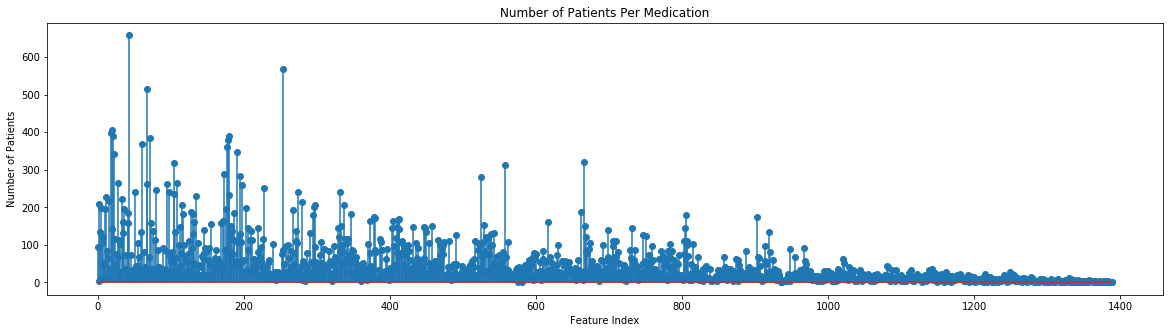

In [ ]:
sums = medtypedata.sum(axis=0)
sums = np.asarray(list(sums[1:]))
print(len(list(medtypedata.columns[1:])))
print(len(sums))
plt.figure(figsize=(20,5))
plt.stem(sums)
plt.title('Number of Patients Per Medication')
plt.xlabel('Feature Index')
plt.ylabel('Number of Patients')
plt.show()

In [10]:
# Getting medications associated with each GTC
gtcs = list(medication_all['gtc'].drop_duplicates())
print(gtcs)
print()
# for g in gtcs:
#     meds = medication_all[medication_all['gtc'] == g]['drugname'].drop_duplicates()
#     print(g)
#     print(list(meds))
#     print()

gtc_of_interest = 41
meds = medication_all[medication_all['gtc'] == gtc_of_interest]['drugname'].drop_duplicates()
print(gtc_of_interest)
print(list(meds))

[0, 59, 35, 99, 9, 41, 95, 65, 2, 19, 44, 83, 56, 17, 94, 92, 80, 62, 38, 5, 11, 71, 89, 32, 68, 53, 20, 14, 36, 50, 86, 23, 77, 22, 29, 74, 97, 72, 18, 26, 21, 25, 34, 47, 98, 3]

41
['LOPRESSOR', 'APRESOLINE', 'LABETALOL 5 MG/1ML 20ML MDV INJ', nan, 'SIMVASTATIN 40 MG PO TABS', 'PRAVASTATIN SODIUM 40 MG PO TABS', 'HYDRALAZINE HCL', 'hydrALAZINE 20 MG/1 ML 1 ML INJ', 'PHENYLEPHRINE 40 MG in 250 mL NS', 'meTOPROLOL tartrate', 'hydrALAZINE', 'LABETALOL', 'HYDRALAZINE', 'METOPROLOL TARTRATE', 'CLONIDINE HCL', 'ATENOLOL', '5 ML  -  METOPROLOL TARTRATE 1 MG/ML IV SOLN', 'metoprolol', 'atorvastatin', 'metoprolol tartrate', 'labetalol', 'ATORVASTATIN', 'METOPROLOL', 'lisinopril', 'NORMODYNE;TRANDATE', 'ZOCOR', 'LABETALOL HCL 5 MG/ML IV SOLN', 'METOPROLOL TARTRATE 25 MG TAB', 'metoprolol tartrate (LOPRESSOR) inj 5 mg', 'metoprolol (LOPRESSOR) tab 25 mg', '5 ML VIAL: METOPROLOL TARTRATE 1 MG/ML IV SOLN', 'METOPROLOL TARTRATE 25 MG PO TABS', 'ATORVASTATIN CALCIUM 40 MG PO TABS', '1 ML VIAL: HYD

# Infusion Data

In [23]:
# Loading infusion data
infusion_all = pd.read_csv('../data/infusion_data_long_query.csv')

infusion_all.head()

C:\Users\owner\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,infusiondrugid,patientunitstayid,infusionoffset,drugname,drugrate,infusionrate,drugamount,volumeoffluid,patientweight,diagnosisid,patientunitstayid.1,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,0,38313443,1480738,478,Volume (mL)-sodium chloride 0.9 % bolus 250 mL...,250,NaN,NaN,NaN,NaN,21461764,1480738,True,62,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Primary
1,1,36622948,1480738,413,Volume (mL)-sodium chloride 0.9 % bolus 250 mL...,250,NaN,NaN,NaN,NaN,21461764,1480738,True,62,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Primary
2,2,36473945,1480738,33,Volume (mL)-sodium chloride 0.9 % bolus 250 mL...,250,NaN,NaN,NaN,NaN,21461764,1480738,True,62,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Primary
3,3,12023288,892782,3205,Propofol (ml/hr),20.1,NaN,NaN,NaN,NaN,10741773,892782,False,2645,burns/trauma|trauma - CNS|intracranial injury|...,"852.00, S06.6",Primary
4,4,12253566,892782,3145,Fentanyl (ml/hr),2.5,NaN,NaN,NaN,NaN,10741773,892782,False,2645,burns/trauma|trauma - CNS|intracranial injury|...,"852.00, S06.6",Primary


In [ ]:
infusiontypes = list(infusion_all['drugname'].drop_duplicates().dropna())
print(infusiontypes)

['Volume (mL)-sodium chloride 0.9 % bolus 250 mL (ml/hr)', 'Propofol (ml/hr)', 'Fentanyl (ml/hr)', 'Phenylephrine (ml/hr)', 'Cisatracurium IVF Infused (ml/hr)', 'Norepinephrine (ml/hr)', 'Mannitol IVF Infused (ml/hr)', 'Midazolam (ml/hr)', 'Vasopressin (ml/hr)', '3% Sodium Chloride IVF Infused (ml/hr)', 'Nicardipine (ml/hr)', 'Propofol (mcg/kg/min)', 'Nicardipine (mg/hr)', 'Lorazepam', 'Lorazepam (mg/hr)', 'Norepinephrine (mcg/min)', 'Propofol', 'Norepinephrine', 'NS (ml/hr)', 'LORazepam (Ativan) 100 mg Sodium Chloride 0.9% 100 ml  Premix (mg/hr)', 'Morphine 250 mg Sodium Chloride 0.9% 250 ml  Premix (mg/hr)', 'FentaNYL (Sublimaze) 2500 mcg Sodium Chloride 0.9% 250 ml  Premix (mcg/hr)', 'Dexmedetomidine(Precedex) 400 mcg Sodium Chloride 0.9% 100 ml (mcg/kg/hr)', 'Propofol (Diprivan) 1000 mg  100 ml  Premix (mcg/kg/min)', 'Vecuronium (Norcuron) 100 mg Sodium Chloride 0.9% 100 ml (mcg/kg/min)', 'D5/NS  (ml/hr)', 'NSS (ml/hr)', 'Octreotide (mcg/hr)', 'Diltiazem ()', 'epidural (ml/hr)', 'V

In [ ]:
# Getting table of indicator variables for each patient
i = infusiontypes[0]
infusiontypedata = infusion_all[infusion_all['drugname'] == i][['patientunitstayid']].drop_duplicates()
indicator = np.ones((infusiontypedata.shape[0], 1))
infusiontypedata[i] = indicator
# print(np.isnan(medtypedata['drugstartoffset']).any())
for i in infusiontypes[1:]:
    infusiontypedata1 = infusion_all[infusion_all['drugname'] == i][['patientunitstayid']].drop_duplicates()
    indicator = np.ones((infusiontypedata1.shape[0], 1))
    infusiontypedata1[i] = indicator
    infusiontypedata = infusiontypedata.merge(infusiontypedata1, how='outer', on='patientunitstayid')

In [ ]:
infusiontypedata = infusiontypedata.fillna(0)
infusiontypedata.head()

In [ ]:
sums = infusiontypedata.sum(axis=0)
sums = np.asarray(list(sums[1:]))
print(len(list(infusiontypedata.columns[1:])))
print(len(sums))
plt.figure(figsize=(20,5))
plt.stem(sums)
plt.title('Number of Patients Per Infusion')
plt.xlabel('Feature Index')
plt.ylabel('Number of Patients')
plt.show()

# Respiratory Data

In [27]:
# Loading respiratory data
respiratory = pd.read_csv('../data/respiratory_data_long_query.csv')
print("loaded respiratory")

C:\Users\owner\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


loaded respiratory


In [39]:
for c in respiratory.columns:
    print(c)

respcharttype = list(respiratory['respcharttypecat'].drop_duplicates())
print(respcharttype)



respflowsettings = respiratory[respiratory['respcharttypecat'] == 'respFlowSettings']
rfs_types = list(respflowsettings['respchartvaluelabel'].drop_duplicates())

respflowcare = respiratory[respiratory['respcharttypecat'] == 'respFlowCareData']
rfc_types = list(respflowcare['respchartvaluelabel'].drop_duplicates())

respflowptvent = respiratory[respiratory['respcharttypecat'] == 'respFlowPtVentData']
rfpv_types = list(respflowptvent['respchartvaluelabel'].drop_duplicates())

Unnamed: 0
respchartid
patientunitstayid
respchartoffset
respchartentryoffset
respcharttypecat
respchartvaluelabel
respchartvalue
diagnosisid
patientunitstayid.1
activeupondischarge
diagnosisoffset
diagnosisstring
icd9code
diagnosispriority
['respFlowSettings', 'respFlowCareData', 'respFlowPtVentData']


In [43]:
print(rfs_types)
print()
print(rfc_types)
print()
print(rfpv_types)
print()

respflowsettings.head(100)

['TV/kg IBW', 'Tidal Volume (set)', 'FiO2', 'Vent Rate', 'PEEP', 'Pressure Support', 'Pressure Control', 'Pressure to Trigger PS', 'Flow Sensitivity', 'Peak Flow', 'LPM O2', 'PEEP/CPAP', '5. ARDS Eval (M or DNM)', 'CPAP', '4. RSBI (RR/Vt)']

['Head of Bed Elevation', 'Adult Con Pt/Vent InspiratorTV', 'Adult Con Pt/Vent MinuteVentil', 'Adult Con Pt/Vent Spont Rate', 'Adult Con Pt/Vent IBW in Kg', 'Adult Con Setting Set Vt', 'Adult Con Setting Set RR', 'Adult Con Alarms Circuit T (Celsius)', 'Adult Con Alarms Hi Press Alarm', 'Adult Con Pt/Vent SpO2', 'Adult Con Alarms Backup I:E', 'Adult Con Alarms Backup RR', 'Adult Con Alarms Backup PC', 'Adult Con Setting Spont Exp Vt', 'Adult Con Pt/Vent ETCO2', 'Adult Con Pt/Vent ETCO2_', 'O2 Device', 'Oxygen Flow Rate', 'Oxygen Delivery Status', 'FIO2 (%)', 'Insp Flow (l/min)', 'Total RSBI', 'Ventilator Population', 'Mechanical Ventilator High Tidal Volume Alarm', 'Flowtrigger', 'Unit of Measure', 'Endotracheal Tube Placement', 'Endotracheal Tube 

,Unnamed: 0,respchartid,patientunitstayid,respchartoffset,respchartentryoffset,respcharttypecat,respchartvaluelabel,respchartvalue,diagnosisid,patientunitstayid.1,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,0,188502297,2747640,125122,125123,respFlowSettings,TV/kg IBW,7.9811,32146310,2747640,False,508270,neurologic|trauma - CNS|intracranial injury|wi...,"852.00, S06.6",Primary
1,1,188502296,2747640,125122,125123,respFlowSettings,Tidal Volume (set),400,32146310,2747640,False,508270,neurologic|trauma - CNS|intracranial injury|wi...,"852.00, S06.6",Primary
2,2,188502294,2747640,125122,125123,respFlowSettings,FiO2,21,32146310,2747640,False,508270,neurologic|trauma - CNS|intracranial injury|wi...,"852.00, S06.6",Primary
6,6,183611562,2747640,332279,332280,respFlowSettings,TV/kg IBW,7.9811,32146310,2747640,False,508270,neurologic|trauma - CNS|intracranial injury|wi...,"852.00, S06.6",Primary
7,7,183611561,2747640,332279,332280,respFlowSettings,Tidal Volume (set),400,32146310,2747640,False,508270,neurologic|trauma - CNS|intracranial injury|wi...,"852.00, S06.6",Primary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,146,183611560,2747640,332279,332280,respFlowSettings,Vent Rate,10,31994147,2747640,False,137871,neurologic|trauma - CNS|intracranial injury|wi...,"852.00, S06.6",Primary
147,147,183611559,2747640,332279,332280,respFlowSettings,PEEP,5,31994147,2747640,False,137871,neurologic|trauma - CNS|intracranial injury|wi...,"852.00, S06.6",Primary
148,148,183611558,2747640,332279,332280,respFlowSettings,FiO2,21,31994147,2747640,False,137871,neurologic|trauma - CNS|intracranial injury|wi...,"852.00, S06.6",Primary
151,151,183085994,2747640,205875,205875,respFlowSettings,TV/kg IBW,7.9811,31994147,2747640,False,137871,neurologic|trauma - CNS|intracranial injury|wi...,"852.00, S06.6",Primary


In [51]:
# For now, select respflowsettings and respflowptventdata
selected_feat = rfs_types
selected_feat.extend(rfpv_types)
print(selected_feat)
selected_resp_data = pd.concat([respflowsettings, respflowptvent])

['TV/kg IBW', 'Tidal Volume (set)', 'FiO2', 'Vent Rate', 'PEEP', 'Pressure Support', 'Pressure Control', 'Pressure to Trigger PS', 'Flow Sensitivity', 'Peak Flow', 'LPM O2', 'PEEP/CPAP', '5. ARDS Eval (M or DNM)', 'CPAP', '4. RSBI (RR/Vt)', 'SaO2', 'RR (patient)', 'Exhaled TV (patient)', 'Peak Insp. Pressure', 'Mean Airway Pressure', 'Exhaled MV', 'Total RR', 'Exhaled TV (machine)', 'Plateau Pressure', 'Compliance', 'Humidifier Temp', 'A1: High Exhaled Vt', 'B3: Est Mask Leak', 'B2: EPAP', 'B1: IPAP', 'HR', 'ETCO2', 'EtCO2', 'SaO2', 'RR (patient)', 'Exhaled TV (patient)', 'Peak Insp. Pressure', 'Mean Airway Pressure', 'Exhaled MV', 'Total RR', 'Exhaled TV (machine)', 'Plateau Pressure', 'Compliance', 'Humidifier Temp', 'A1: High Exhaled Vt', 'B3: Est Mask Leak', 'B2: EPAP', 'B1: IPAP', 'HR', 'ETCO2', 'EtCO2', 'SaO2', 'RR (patient)', 'Exhaled TV (patient)', 'Peak Insp. Pressure', 'Mean Airway Pressure', 'Exhaled MV', 'Total RR', 'Exhaled TV (machine)', 'Plateau Pressure', 'Compliance', 

In [58]:
resp_data_piv = pd.pivot_table(selected_resp_data, index=['patientunitstayid', 'respchartentryoffset'], columns='respchartvaluelabel', values='respchartvalue', aggfunc='first').reset_index()

In [62]:
print(resp_data_piv.shape)
resp_data_piv = resp_data_piv.fillna(0)
resp_data_piv.head()

(229357, 35)


respchartvaluelabel,patientunitstayid,respchartentryoffset,4. RSBI (RR/Vt),5. ARDS Eval (M or DNM),A1: High Exhaled Vt,B1: IPAP,B2: EPAP,B3: Est Mask Leak,CPAP,Compliance,...,Plateau Pressure,Pressure Control,Pressure Support,Pressure to Trigger PS,RR (patient),SaO2,TV/kg IBW,Tidal Volume (set),Total RR,Vent Rate
0,143103,5,0,0,0,0,0,0,0,0,...,19,0,0,0,0,0,8.4368,500,12,12
1,143103,21,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8.4368,500,0,0
2,143103,218,0,0,0,0,0,0,0,0,...,16,0,0,0,0,0,8.4368,500,13,12
3,143103,377,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8.0994,480,0,0
4,143103,378,0,0,0,0,0,0,0,0,...,13,0,0,0,0,0,8.0994,480,19,18


In [176]:
resp_data = pd.pivot_table(selected_resp_data, index=['patientunitstayid', 'respchartentryoffset'], columns='respchartvaluelabel', values='respchartvalue', aggfunc='first').reset_index()

In [177]:
resp_data.head()

respchartvaluelabel,patientunitstayid,respchartentryoffset,4. RSBI (RR/Vt),5. ARDS Eval (M or DNM),A1: High Exhaled Vt,B1: IPAP,B2: EPAP,B3: Est Mask Leak,CPAP,Compliance,ETCO2,EtCO2,Exhaled MV,Exhaled TV (machine),Exhaled TV (patient),FiO2,Flow Sensitivity,HR,Humidifier Temp,LPM O2,Mean Airway Pressure,PEEP,PEEP/CPAP,Peak Flow,Peak Insp. Pressure,Plateau Pressure,Pressure Control,Pressure Support,Pressure to Trigger PS,RR (patient),SaO2,TV/kg IBW,Tidal Volume (set),Total RR,Vent Rate
0,143103,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,8.4368,500,12,12
1,143103,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.4368,500,NaN,NaN
2,143103,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,8.4368,500,13,12
3,143103,377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0994,480,NaN,NaN
4,143103,378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,8.0994,480,19,18


In [178]:
print(resp_data['ETCO2'].dropna().shape)
print(resp_data['EtCO2'].dropna().shape)

(497,)
(288,)


In [179]:
columns_to_drop = ['EtCO2','RR (patient)', 'Total RR', 'HR', 'SaO2', '5. ARDS Eval (M or DNM)']
resp_data = resp_data.drop(columns=columns_to_drop)
resp_data['FiO2'] = [float(str(i).strip('%'))/100 for i in list(resp_data['FiO2'])]
for col in resp_data.columns:
    if col != 'patientunitstayid' and col != 'respchartentryoffset':
        print(col)
        print(resp_data[col].dtypes)
        resp_data[col] = resp_data[col].astype(float)

4. RSBI (RR/Vt)
object
A1: High Exhaled Vt
object
B1: IPAP
object
B2: EPAP
object
B3: Est Mask Leak
object
CPAP
object
Compliance
object
ETCO2
object
Exhaled MV
object
Exhaled TV (machine)
object
Exhaled TV (patient)
object
FiO2
float64
Flow Sensitivity
object
Humidifier Temp
object
LPM O2
object
Mean Airway Pressure
object
PEEP
object
PEEP/CPAP
object
Peak Flow
object
Peak Insp. Pressure
object
Plateau Pressure
object
Pressure Control
object
Pressure Support
object
Pressure to Trigger PS
object
TV/kg IBW
object
Tidal Volume (set)
object
Vent Rate
object


In [180]:
resp_data_indicator = resp_data.fillna(0)
for col in resp_data_indicator.columns:
    if col != 'patientunitstayid' and col != 'respchartentryoffset':
        print(col)
        data = list(resp_data_indicator[col])
        data = [1 if data[i] != 0 else 0 for i in range(len(data))]
        resp_data_indicator[col] = data
    
resp_data_indicator.head()

4. RSBI (RR/Vt)
A1: High Exhaled Vt
B1: IPAP
B2: EPAP
B3: Est Mask Leak
CPAP
Compliance
ETCO2
Exhaled MV
Exhaled TV (machine)
Exhaled TV (patient)
FiO2
Flow Sensitivity
Humidifier Temp
LPM O2
Mean Airway Pressure
PEEP
PEEP/CPAP
Peak Flow
Peak Insp. Pressure
Plateau Pressure
Pressure Control
Pressure Support
Pressure to Trigger PS
TV/kg IBW
Tidal Volume (set)
Vent Rate


respchartvaluelabel,patientunitstayid,respchartentryoffset,4. RSBI (RR/Vt),A1: High Exhaled Vt,B1: IPAP,B2: EPAP,B3: Est Mask Leak,CPAP,Compliance,ETCO2,Exhaled MV,Exhaled TV (machine),Exhaled TV (patient),FiO2,Flow Sensitivity,Humidifier Temp,LPM O2,Mean Airway Pressure,PEEP,PEEP/CPAP,Peak Flow,Peak Insp. Pressure,Plateau Pressure,Pressure Control,Pressure Support,Pressure to Trigger PS,TV/kg IBW,Tidal Volume (set),Vent Rate
0,143103,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1
1,143103,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,143103,218,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1
3,143103,377,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,143103,378,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1


In [181]:
# Getting totals for each column to see how many patients actually had these
more_cols_todrop = []
for col in resp_data_indicator.columns:
    if col != 'patientunitstayid' and col != 'respchartentryoffset':
        data = list(resp_data_indicator[col])
        tot = sum(data)
        proportion_with = tot/len(data)
#         print(proportion_with)
        if proportion_with < 0.2:
            more_cols_todrop.append(col)
print(len(resp_data_indicator.columns))
print(len(more_cols_todrop))
print(more_cols_todrop)

29
22
['4. RSBI (RR/Vt)', 'A1: High Exhaled Vt', 'B1: IPAP', 'B2: EPAP', 'B3: Est Mask Leak', 'CPAP', 'Compliance', 'ETCO2', 'Exhaled MV', 'Exhaled TV (machine)', 'Exhaled TV (patient)', 'Flow Sensitivity', 'Humidifier Temp', 'LPM O2', 'Mean Airway Pressure', 'PEEP/CPAP', 'Peak Flow', 'Peak Insp. Pressure', 'Plateau Pressure', 'Pressure Control', 'Pressure Support', 'Pressure to Trigger PS']


In [183]:
# Dropping additional columns
more_discarded = resp_data_indicator.drop(columns=more_cols_todrop)
more_discarded.head()

respchartvaluelabel,patientunitstayid,respchartentryoffset,FiO2,PEEP,TV/kg IBW,Tidal Volume (set),Vent Rate
0,143103,5,1,1,1,1,1
1,143103,21,0,0,1,1,0
2,143103,218,1,1,1,1,1
3,143103,377,0,0,1,1,0
4,143103,378,1,1,1,1,1


## Set Parameters

In [24]:
# prediction frequency refers to the frequency with which we want to predict GCS
prediction_freq = 2

# summarization interval refers to the spacing between edges of the bins of our histogram (for summarizing physiology)
summarization_int = 0.8

## Bin data

In [25]:
# split data into bins based on summarization_int
bins=np.arange(25, step=summarization_int)
hr['offset_bin'] = pd.cut(hr['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
#display(hr[hr['patientunitstayid'] == 318676])
hr_grouped = hr.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#hr_grouped['patientunitstayid'] = hr_grouped['patientunitstayid'].astype(int)

resp['offset_bin'] = pd.cut(resp['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
resp_grouped = resp.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#resp_grouped['patientunitstayid'] = resp_grouped['patientunitstayid'].astype(int)

sao2['offset_bin'] = pd.cut(sao2['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
sao2_grouped = sao2.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#sao2_grouped['patientunitstayid'] = sao2_grouped['patientunitstayid'].astype(int)

gcs['offset_bin'] = pd.cut(gcs['observationoffset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
gcs_grouped = gcs.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
gcs_grouped['offset'] = gcs_grouped['observationoffset']
gcs_grouped['value'] = gcs_grouped['Value']
gcs_grouped = gcs_grouped.drop(['observationoffset', 'Value'], axis = 1)
#gcs_grouped['patientunitstayid'] = gcs_grouped['patientunitstayid'].astype(int)

## Plot Samples

In [26]:
# get one patient's data
ind_slice = np.argwhere(hr_grouped['patientunitstayid'] == 1020525).flatten()
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(15,10))
f.suptitle("Patient 1020525", size = 20)
ax1.plot(np.arange(resp_grouped[resp_grouped.index.isin(ind_slice)]['value'].shape[0]),
         resp_grouped[resp_grouped.index.isin(ind_slice)]['value'])
ax1.set_title("Respiratory")

ax2.plot(np.arange(hr_grouped[hr_grouped.index.isin(ind_slice)]['value'].shape[0]),
         hr_grouped[hr_grouped.index.isin(ind_slice)]['value'])
ax2.set_title("HR")

ax3.plot(np.arange(sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'].shape[0]),
         sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'])
ax3.set_title("SaO2")

ax4.scatter(gcs_grouped[gcs_grouped.index.isin(ind_slice)]['offset_bin'], gcs_grouped[gcs_grouped.index.isin(ind_slice)]['value'])
ax4.set_title("Motor GCS")

ValueError: Length of passed values is 1, index implies 94302.

## Prepare Datasets

In [ ]:
# interpolate signal
hr_first24 = hr_grouped.copy()
resp_first24 = resp_grouped.copy()
sao2_first24 = sao2_grouped.copy()
gcs_first24 = gcs_grouped.copy()

hr_first24['value'] = hr_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
resp_first24['value'] = resp_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
sao2_first24['value'] = sao2_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
gcs_first24['value'] = gcs_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']

In [ ]:
# get first 24 hrs
myInt = 24.0 / summarization_int

hr_first24 = hr_first24.loc[hr_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])
resp_first24 = resp_first24.loc[resp_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])
sao2_first24 = sao2_first24.loc[sao2_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])
gcs_first24 = gcs_first24.loc[gcs_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])

# fill remaining na fields (beginning of patient stay if any) with overall signal mean (maybe median itf?)
hr_first24['value'] = hr_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))
resp_first24['value'] = resp_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))
sao2_first24['value'] = sao2_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))
gcs_first24['value'] = gcs_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))

#hr_first24['value'] = hr_first24.groupby('patientunitstayid').transform(lambda x: x.median())
#resp_first24['value'] = resp_first24.groupby('patientunitstayid').transform(lambda x: x.median())
#sao2_first24['value'] = sao2_first24.groupby('patientunitstayid').transform(lambda x: x.median())
#gcs_first24['value'] = gcs_first24.groupby('patientunitstayid').transform(lambda x: x.median())

#display(resp_first24)
#display(sao2_first24)

In [ ]:
further_exclusion = hr_first24.loc[hr_first24.isna()['value']]['patientunitstayid'].unique()
further_exclusion = np.hstack([further_exclusion, resp_first24.loc[resp_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, sao2_first24.loc[sao2_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, gcs_first24.loc[gcs_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.unique(further_exclusion)
#print(further_exclusion.shape)

In [ ]:
# organize by patient

# first grab all the patient ids

# ISSUE: some patients are not represented, need to think of how to include them, perhaps -1?
keys1, keys2, keys3, keys4 = hr['patientunitstayid'].unique(), resp['patientunitstayid'].unique(), sao2['patientunitstayid'].unique(), final_gcs['patientunitstayid'].unique()
keys = []
for k in keys1:
    if (k in keys2) and (k in keys3) and (k in keys4) and (k not in further_exclusion):
        keys.append(k)

# now stack data based on the same patient order
X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_hr = X_hr.T
X_resp = X_resp.T
X_sao2 = X_sao2.T
X_gcs = X_gcs.T
#print(X_gcs)

# Modeling

In [ ]:
# SET PARAMETERS

# number of pca components to extract
num_components = 40

# number of fourier features to extract
num_fourier_components = 40

# choose resampling technique
resampling = 'over'

# select model family
model_family = 'logistic'

In [ ]:
id_df = pd.DataFrame(keys, columns =['patientunitstayid'])
# id_df.head()
labtypedata_cts_allids = labtypedata_cts.merge(id_df, how='right', on='patientunitstayid')
labtypedata_cts_allids = labtypedata_cts_allids.fillna(0)
#print(labtypedata_cts_allids.shape)
labtypedata_cts_allids.head()

In [ ]:
labtypedata_avgs_allids = labtypedata_avgs.merge(id_df, how='right', on='patientunitstayid')
#print(labtypedata_avgs_allids.shape)
for l in labtypedata_avgs_allids.columns:
    if l != 'patientunitstayid':
        col = labtypedata_avgs_allids[l]
        labtypedata_avgs_allids[l] = col.fillna(lab_avgs_map[l])
# labtypedata_avgs_allids = labtypedata_avgs_allids.fillna(-1)
#labtypedata_avgs_allids.head()

In [ ]:
dem_allids = demographic.merge(id_df, how='right', on='patientunitstayid')
dem_allids = dem_allids.drop_duplicates()
#print(dem_allids.shape)
dem_allids = dem_allids.fillna(dem_allids.mean())
print(dem_allids.shape)
# labtypedata_avgs_allids = labtypedata_avgs_allids.fillna(-1)
#dem_allids.head()

death = died.merge(id_df, how = 'right', on = 'patientunitstayid')
print(death.shape)
# death.head()
# deathstatus = death['alive'].values[:, np.newaxis]
# print(deathstatus)
# print(np.isnan(deathstatus).any())

In [ ]:
medication_allids = medtypedata.merge(id_df, how='right', on='patientunitstayid')
print(medication_allids.shape)
# Filling in NA with 0
medication_allids = medication_allids.fillna(0)

medication_allids.head()

In [ ]:
infusion_allids = infusiontypedata.merge(id_df, how='right', on='patientunitstayid')
print(infusion_allids.shape)
# Filling in NA with 0
infusion_allids = infusion_allids.fillna(0)

infusion_allids.head()

In [ ]:
labavg_cols = []
for c in labtypedata_avgs_allids.columns:
    if c != 'patientunitstayid':
        labavg_cols.append(c)
X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
        None] for g in keys])[0]

labcts_cols = []
for c in labtypedata_cts_allids.columns:
    if c != 'patientunitstayid':
        labcts_cols.append(c)
X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
        None] for g in keys])[0]

dem_cols = []
for c in dem_allids.columns:
    if c != 'patientunitstayid':
        dem_cols.append(c)
X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

In [ ]:
death.head()

In [ ]:
# Re-ordering the death mortality columns based on patientunitstayid
death_cols = ['alive']
deathstatus = np.hstack([death.loc[death['patientunitstayid'] == g][death_cols].values[:,None] for g in keys])[0]
print(deathstatus)

In [ ]:
medication_cols = []
for c in medication_allids.columns:
    if c != 'patientunitstayid':
        medication_cols.append(c)
X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

infusion_cols = []
for c in infusion_allids.columns:
    if c != 'patientunitstayid':
        infusion_cols.append(c)
X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

In [ ]:
# Aligning final GCS with mortality
id_df.head()
final_gcs_finalids = final_gcs.merge(id_df, on='patientunitstayid', how='right')
died_finalids = died.merge(id_df, on='patientunitstayid', how='right')
print(final_gcs_finalids.shape)
print(np.isnan(final_gcs_finalids['Value']).any())
print(died_finalids.shape)
print(np.isnan(died_finalids['alive']).any())

# Merging the final_gcs_finalids and died_finalids based on patientunitstayid
gcs_mortality_comb = final_gcs_finalids.merge(died_finalids, on='patientunitstayid')[['patientunitstayid','Value','alive']]
gcs_mortality_comb.rename(columns={'Value':'final_gcs'}, inplace=True)
# display(gcs_mortality_comb)

# Finding patients that died and have GCS=6
died_gcs6 = gcs_mortality_comb[gcs_mortality_comb['final_gcs'] == 6.0]
died_gcs6 = died_gcs6[died_gcs6['alive'] == False]
display(died_gcs6.head())
died_gcs6_ids = list(died_gcs6['patientunitstayid'])
print(died_gcs6_ids)

# Feature Selection using Lasso Regression

In [ ]:
mort = False
discard_dead = True

if mort and discard_dead:
    raise ValueError('invalid option')

if (not mort) and (discard_dead):
    # Removing the patients who have GCS = 6 and died
    newkeys = []
    for k in keys:
        if k not in died_gcs6_ids:
            newkeys.append(k)

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in newkeys])

        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in newkeys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in newkeys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in newkeys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in newkeys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in newkeys])[0]

else:
        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in keys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in keys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in keys])

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_med)
X_med_pca = raw_pca.transform(scaler.fit_transform(X_med))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_infusion)
X_infusion_pca = raw_pca.transform(scaler.fit_transform(X_infusion))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   

else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

X_labdem = np.hstack([X_med, X_infusion])
X_naive = X_labdem

# split data
if mort:
    trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()
else:
    trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()

# resample
if resampling == 'over':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
        
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

In [ ]:
# modify labels
if mort:
    testY_mod = testY.astype(int)
#     testY_mod[testY == False] = 0
#     testY_mod[testY == True] = 1

    trainY_mod = trainY.astype(int)
#     trainY_mod = trainY.copy()
#     trainY_mod[trainY ==False] = 0
#     trainY_mod[trainY == True] = 1
else:
    testY_mod = testY.copy()
    testY_mod[testY < 6] = 1
    testY_mod[testY == 6] = 0

    trainY_mod = trainY.copy()
    trainY_mod[trainY < 6] = 1
    trainY_mod[trainY == 6] = 0
    
# train feature-selector
clf = LogisticRegression(max_iter=2000, penalty='l1', l1_ratio=0.5,
                         solver='saga', C=.05)

print(trainX.shape)
clf.fit(trainX, trainY_mod)
print("Train Score:", clf.score(trainX, trainY_mod))

In [ ]:
lasso_coeff = clf.coef_[0]
print('Total columns: ' + str(len(lasso_coeff)))
lasso_indices = [x[0] for x in np.argwhere(clf.coef_[0] != 0).tolist()]
print('Indices of concatenated medication and infusion columns: ' + str(lasso_indices))
print(len(lasso_indices))
print(X_labdem.shape)
X_med_infusion_selected = X_labdem[:,lasso_indices]
print(X_med_infusion_selected.shape)

# getting column names
med_inf_colnames = list(medication_cols) + list(infusion_cols)
# print(med_inf_colnames)
selected_meds = np.asarray(med_inf_colnames)[lasso_indices]
print(selected_meds)
for m in selected_meds:
    print(m)

# Alternatively, Computing P-Values

In [ ]:
print(X_dem)

In [ ]:
mort = False
discard_dead = True

if mort and discard_dead:
    raise ValueError('invalid option')

if (not mort) and (discard_dead):
    # Removing the patients who have GCS = 6 and died
    newkeys = []
    for k in keys:
        if k not in died_gcs6_ids:
            newkeys.append(k)

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in newkeys])

        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in newkeys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in newkeys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in newkeys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in newkeys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in newkeys])[0]

else:
        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in keys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in keys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in keys])

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_med)
X_med_pca = raw_pca.transform(scaler.fit_transform(X_med))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_infusion)
X_infusion_pca = raw_pca.transform(scaler.fit_transform(X_infusion))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   

else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

# X_labdem = np.hstack([X_labavgs, X_labcts, X_dem, X_med, X_infusion])
X_labdem = np.hstack([X_labavgs])
X_naive = X_labdem

# split data
if mort:
    trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()
else:
    trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()

# resample
if resampling == 'over':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
        
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

In [ ]:
# modify labels
if mort:
    testY_mod = testY.astype(int)
#     testY_mod[testY == False] = 0
#     testY_mod[testY == True] = 1

    trainY_mod = trainY.astype(int)
#     trainY_mod = trainY.copy()
#     trainY_mod[trainY ==False] = 0
#     trainY_mod[trainY == True] = 1
else:
    testY_mod = testY.copy()
    testY_mod[testY < 6] = 1
    testY_mod[testY == 6] = 0

    trainY_mod = trainY.copy()
    trainY_mod[trainY < 6] = 1
    trainY_mod[trainY == 6] = 0

In [ ]:
# compare with statsmodels
import statsmodels.api as sm
sm_model = sm.Logit(trainY_mod, sm.add_constant(trainX)).fit(method='bfgs',disp=0)
print(sm_model.pvalues)
colnames = labavg_cols+dem_cols
print(trainX.shape)
print(colnames)
print(len(colnames))
sm_model.summary()

In [ ]:
pvalue_ranking_labavgs = pd.DataFrame(list(zip(sm_model.pvalues, labavg_cols)), 
               columns =['pvalue', 'feature'])
pvalue_ranking_labavgs = pvalue_ranking_labavgs.sort_values(by=['pvalue'])
display(pvalue_ranking_labavgs)

# Alternatively, selecting medication and infusion features separately

In [ ]:
mort = False
discard_dead = True

if mort and discard_dead:
    raise ValueError('invalid option')

if (not mort) and (discard_dead):
    # Removing the patients who have GCS = 6 and died
    newkeys = []
    for k in keys:
        if k not in died_gcs6_ids:
            newkeys.append(k)

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in newkeys])

        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in newkeys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in newkeys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in newkeys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in newkeys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in newkeys])[0]

else:
        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in keys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in keys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in keys])

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_med)
X_med_pca = raw_pca.transform(scaler.fit_transform(X_med))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_infusion)
X_infusion_pca = raw_pca.transform(scaler.fit_transform(X_infusion))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   

else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

In [ ]:
lasso_indices = []
for t in [X_med, X_infusion]:
    X_labdem = np.hstack([t])
    X_naive = X_labdem

    # split data
    if mort:
        trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
        trainY, testY = trainY.flatten(), testY.flatten()
    else:
        trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
        trainY, testY = trainY.flatten(), testY.flatten()

    # resample
    if resampling == 'over':
        if mort:
            positive = np.argwhere(trainY.flatten() == False).flatten()
            negative = np.argwhere(trainY.flatten() == True).flatten()
        else:
            positive = np.argwhere(trainY.flatten() < 6).flatten()
            negative = np.argwhere(trainY.flatten() == 6).flatten()

        X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
        X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])

        X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
        stacked = np.vstack([X_positive, X_negative])
        np.random.shuffle(stacked)

        trainX = stacked[:, :-1]
        trainY = stacked[:, -1]

    elif resampling == 'under':
        if mort:
            positive = np.argwhere(trainY.flatten() == False).flatten()
            negative = np.argwhere(trainY.flatten() == True).flatten()
        else:
            positive = np.argwhere(trainY.flatten() < 6).flatten()
            negative = np.argwhere(trainY.flatten() == 6).flatten()

        X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
        X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])

        X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
        stacked = np.vstack([X_positive, X_negative])
        np.random.shuffle(stacked)

        trainX = stacked[:, :-1]
        trainY = stacked[:, -1]
        
    # modify labels
    if mort:
        testY_mod = testY.astype(int)
    #     testY_mod[testY == False] = 0
    #     testY_mod[testY == True] = 1

        trainY_mod = trainY.astype(int)
    #     trainY_mod = trainY.copy()
    #     trainY_mod[trainY ==False] = 0
    #     trainY_mod[trainY == True] = 1
    else:
        testY_mod = testY.copy()
        testY_mod[testY < 6] = 1
        testY_mod[testY == 6] = 0

        trainY_mod = trainY.copy()
        trainY_mod[trainY < 6] = 1
        trainY_mod[trainY == 6] = 0

    # train feature-selector
    clf = LogisticRegression(max_iter=2000, penalty='l1', l1_ratio=0.5,
                             solver='saga', C=.05)

    print(trainX.shape)
    clf.fit(trainX, trainY_mod)
    print("Train Score:", clf.score(trainX, trainY_mod))
    
    lasso_coeff = clf.coef_[0]
    print('Total columns: ' + str(len(lasso_coeff)))
    lasso_indices_pre = [x[0] for x in np.argwhere(clf.coef_[0] != 0).tolist()]
    print('Indices of selected columns: ' + str(lasso_indices_pre))
    print(len(lasso_indices_pre))
    print(X_labdem.shape)
    lasso_indices.append(lasso_indices_pre)

X_med_lasso = X_med[lasso_indices[0]]
X_infusion_lasso = X_infusion[lasso_indices[1]]

# getting column names
selected_meds = np.asarray(medication_cols)[lasso_indices[0]]
selected_infusions = np.asarray(infusion_cols)[lasso_indices[1]]
print('--------------Selected Medications-----------------')
print(selected_meds)
for m in selected_meds:
    print(m)

print()

print('--------------Selected Infusions---------------')
print(selected_infusions)
for i in selected_infusions:
    print(i)

# Training Models

In [ ]:
if (not mort) and (discard_dead):
    # Removing the patients who have GCS = 6 and died
    newkeys = []
    for k in keys:
        if k not in died_gcs6_ids:
            newkeys.append(k)

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in newkeys])

        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in newkeys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in newkeys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in newkeys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in newkeys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in newkeys])[0]

else:
        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in keys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in keys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in keys])

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_med)
X_med_pca = raw_pca.transform(scaler.fit_transform(X_med))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_infusion)
X_infusion_pca = raw_pca.transform(scaler.fit_transform(X_infusion))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   

else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

X_labdem = np.hstack([X_labavgs, X_labcts, X_dem, X_med_infusion_selected])
scaler.fit(X_labdem)
X_labdem = scaler.transform(X_labdem)
X_naive = np.hstack([X_phys, X_labdem])

# split data
if mort:
    trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()
else:
    trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()

# resample
if resampling == 'over':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
        
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

In [ ]:
# modify labels
if mort:
    testY_mod = testY.astype(int)
#     testY_mod[testY == False] = 0
#     testY_mod[testY == True] = 1

    trainY_mod = trainY.astype(int)
#     trainY_mod = trainY.copy()
#     trainY_mod[trainY ==False] = 0
#     trainY_mod[trainY == True] = 1
else:
    testY_mod = testY.copy()
    testY_mod[testY < 6] = 1
    testY_mod[testY == 6] = 0

    trainY_mod = trainY.copy()
    trainY_mod[trainY < 6] = 1
    trainY_mod[trainY == 6] = 0
    
# train model
model_family = 'logistic'
if model_family == 'logistic':
    clf = LogisticRegression(max_iter=2000, penalty='elasticnet', l1_ratio=0.5,
                         solver='saga', C=0.5)
    
elif model_family == 'random_forest':
    clf = RandomForestClassifier(max_depth=2, n_estimators=10)

print(trainX.shape)
clf.fit(trainX, trainY_mod)
print("Train Score:", clf.score(trainX, trainY_mod))

In [ ]:
# test model
predY = clf.predict_proba(testX)[:, 1]
print("Test Score:", np.round(clf.score(testX, testY_mod), 4))

# get auc
auc = roc_auc_score(testY_mod, predY)
print("AUC:", np.round(auc, 4))

# plot roc curve
fpr, tpr, roc_thresholds = roc_curve(testY_mod, predY)
precision, recall, thresholds = precision_recall_curve(testY_mod, predY)

# optimize for precision and recall
best_pr_thresh = np.argmax(np.square(precision) + np.square(recall))

# find corresponding threshold index for roc curve (thresholds are reverse order)
# roc_thresh = int(roc_thresholds.shape[0] * (1 - best_pr_thresh / thresholds.shape[0]))
roc_thresh = np.argmax(np.square(tpr) + np.square(1 - fpr))
#print('roc thresh:', roc_thresholds.shape)
#print('pr thresh:', thresholds.shape)

print("Sensitivity: " + str(np.round(tpr[roc_thresh], 4)))
print("Specificity: " + str(np.round(1 - fpr[roc_thresh], 4)))
print("Precision: " + str(np.round(precision[best_pr_thresh], 4)))
print("Recall: " + str(np.round(recall[best_pr_thresh], 4)))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

plt.figure()
average_precision = average_precision_score(testY_mod, predY)
disp = plot_precision_recall_curve(clf, testX, testY_mod)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.show()
# class balance
plt.hist(testY_mod, bins=2, weights=np.ones(len(testY_mod)) / len(testY_mod))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Ground Truth")
plt.show()

plt.hist(predY, bins=2, weights=np.ones(len(predY)) / len(predY))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Predicted")
plt.show()

# heatmap
predY = predY > thresholds[best_pr_thresh]
confusion = confusion_matrix(predY, testY_mod)
confusion = confusion / np.sum(confusion, axis=1)[:, None]
heatmap = sns.heatmap(confusion, linewidths=.5, cmap="YlGnBu")

# Combining mortality and GCS

In [ ]:
# Splitting into three categories:
# 1. dead
# 2. alive with deficits (GCS < 6)
# 3. alive without deficits (GCS = 6)

# final_gcs_id = gcs.groupby('patientunitstayid')['observationoffset'].transform(max) == gcs['observationoffset']
# final_gcs = gcs[final_gcs_id]

# Combining the final_GCS information and mortality
print(final_gcs.shape)
# final_gcs.head()
print(died.shape)
died.head()

In [ ]:
# First extracting ids that will be used
id_df.head()
final_gcs_finalids = final_gcs.merge(id_df, on='patientunitstayid', how='right')
died_finalids = died.merge(id_df, on='patientunitstayid', how='right')
print(final_gcs_finalids.shape)
print(np.isnan(final_gcs_finalids['Value']).any())
print(died_finalids.shape)
print(np.isnan(died_finalids['alive']).any())

# Merging the final_gcs_finalids and died_finalids based on patientunitstayid
gcs_mortality_comb = final_gcs_finalids.merge(died_finalids, on='patientunitstayid')[['patientunitstayid','Value','alive']]
gcs_mortality_comb.rename(columns={'Value':'final_gcs'}, inplace=True)

In [ ]:
gcs_mortality_comb.head()

In [ ]:
# Categorizing each patient as one of three classes
# (dead, alive with GCS<6, alive with GCS=6)
dead = gcs_mortality_comb[gcs_mortality_comb['alive'] == False]
alive = gcs_mortality_comb[gcs_mortality_comb['alive'] == True]
alive_deficit = alive[alive['final_gcs'] != 6.0]
alive_nodeficit = alive[alive['final_gcs'] == 6.0]
print(dead.shape)
print(alive.shape)
print(alive_deficit.shape)
print(alive_nodeficit.shape)
# dead.head()

# Adding column to each df corresponding to class
# 0: dead, 1: alive with deficit, 2: alive without deficit
dead['class'] = np.zeros((dead.shape[0], 1), dtype=int)
alive_deficit['class'] = np.ones((alive_deficit.shape[0], 1), dtype=int)
alive_nodeficit['class'] = np.ones((alive_nodeficit.shape[0], 1), dtype=int)*2

# Unioning the three dataframes
gcs_mortality_class = pd.concat([dead, alive_deficit, alive_nodeficit])
print(gcs_mortality_class.shape)
gcs_mortality_class.head()

In [ ]:
# Reordering the rows to match other data sources
gcs_mortality_labels = np.hstack([gcs_mortality_class.loc[gcs_mortality_class['patientunitstayid'] == g]['class'].values[:,None] for g in keys])[0]

In [ ]:
mort = True
scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   

else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

X_labdem = np.hstack([X_labavgs, X_labcts, X_dem])
scaler.fit(X_labdem)
X_labdem = scaler.transform(X_labdem)

X_naive = np.hstack([X_phys, X_labdem])
target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
        None] for g in keys])

# split data
trainX, testX, trainY, testY = train_test_split(X_naive, gcs_mortality_labels, test_size=0.3, random_state = 8055)
trainY, testY = trainY.flatten(), testY.flatten()

# resample
if resampling == 'over':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
        
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

In [ ]:
# modify labels
testY_mod = testY
trainY_mod = trainY
    
# train model
model_family = 'logistic'
if model_family == 'logistic':
    clf = LogisticRegression(max_iter=2000, penalty='elasticnet', l1_ratio=0.5,
                         solver='saga', C=.8)
    
elif model_family == 'random_forest':
    clf = RandomForestClassifier(max_depth=2, n_estimators=10)

print(trainX.shape)
clf.fit(trainX, trainY_mod)
print("Train Score:", clf.score(trainX, trainY_mod))

# Bootstrapping

In [ ]:
stats=pd.DataFrame(columns=['Train Score', 'Test Score', 'AUC', 'bestThreshInd1',  'bestThreshInd',
                            'Precision','Recall'])
roc_data=[]
thetas=pd.DataFrame()
betas=[]
tr_acc=[]
test_acc=[]

mort = False

for run in range(10):
    # split data
    if mort:
        trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
        trainY, testY = trainY.flatten(), testY.flatten()
    else:
        trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
        trainY, testY = trainY.flatten(), testY.flatten()

    # resample
    if resampling == 'over':
        if mort:
            positive = np.argwhere(trainY.flatten() == False).flatten()
            negative = np.argwhere(trainY.flatten() == True).flatten()
        else:
            positive = np.argwhere(trainY.flatten() < 6).flatten()
            negative = np.argwhere(trainY.flatten() == 6).flatten()

        X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
        X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])

        X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
        stacked = np.vstack([X_positive, X_negative])
        np.random.shuffle(stacked)

        trainX = stacked[:, :-1]
        trainY = stacked[:, -1]

    elif resampling == 'under':
        if mort:
            positive = np.argwhere(trainY.flatten() == False).flatten()
            negative = np.argwhere(trainY.flatten() == True).flatten()
        else:
            positive = np.argwhere(trainY.flatten() < 6).flatten()
            negative = np.argwhere(trainY.flatten() == 6).flatten()

        X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
        X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])

        X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
        stacked = np.vstack([X_positive, X_negative])
        np.random.shuffle(stacked)

        trainX = stacked[:, :-1]
        trainY = stacked[:, -1]
    
    # modify labels
    if mort:
        testY_mod = testY.astype(int)
    
        trainY_mod = trainY.astype(int)

    else:
        testY_mod = testY.copy()
        testY_mod[testY < 6] = 1
        testY_mod[testY == 6] = 0

        trainY_mod = trainY.copy()
        trainY_mod[trainY < 6] = 1
        trainY_mod[trainY == 6] = 0

    # train feature-selector
    clf = LogisticRegression(max_iter=2000, penalty='l1', l1_ratio=0.5,
                             solver='saga', C=.05)

    clf.fit(trainX, trainY_mod)

    lasso_coeff = clf.coef_[0]
    lasso_indices = [x[0] for x in np.argwhere(clf.coef_[0] != 0).tolist()]
    X_med_infusion_selected = X_labdem[:,lasso_indices]

    # getting column names
    med_inf_colnames = list(medication_allids.columns) + list(infusion_allids.columns)

    if (not mort) and (discard_dead):
        # Removing the patients who have GCS = 6 and died
        newkeys = []
        for k in keys:
            if k not in died_gcs6_ids:
                newkeys.append(k)

        target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
                None] for g in newkeys])

            # now stack data based on the same patient order
        X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in newkeys])

        X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in newkeys])

        X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in newkeys])

        X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in newkeys])

        X_hr = X_hr.T
        X_resp = X_resp.T
        X_sao2 = X_sao2.T
        X_gcs = X_gcs.T

        labavg_cols = []
        for c in labtypedata_avgs_allids.columns:
            if c != 'patientunitstayid':
                labavg_cols.append(c)
        X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
                None] for g in newkeys])[0]

        labcts_cols = []
        for c in labtypedata_cts_allids.columns:
            if c != 'patientunitstayid':
                labcts_cols.append(c)
        X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
                None] for g in newkeys])[0]

        dem_cols = []
        for c in dem_allids.columns:
            if c != 'patientunitstayid':
                dem_cols.append(c)
        X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in newkeys])[0]

        medication_cols = []
        for c in medication_allids.columns:
            if c != 'patientunitstayid':
                medication_cols.append(c)
        X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in newkeys])[0]

        infusion_cols = []
        for c in infusion_allids.columns:
            if c != 'patientunitstayid':
                infusion_cols.append(c)
        X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in newkeys])[0]

    else:
            # now stack data based on the same patient order
        X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in keys])

        X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in keys])

        X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in keys])

        X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in keys])

        X_hr = X_hr.T
        X_resp = X_resp.T
        X_sao2 = X_sao2.T
        X_gcs = X_gcs.T

        labavg_cols = []
        for c in labtypedata_avgs_allids.columns:
            if c != 'patientunitstayid':
                labavg_cols.append(c)
        X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
                None] for g in keys])[0]

        labcts_cols = []
        for c in labtypedata_cts_allids.columns:
            if c != 'patientunitstayid':
                labcts_cols.append(c)
        X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
                None] for g in keys])[0]

        dem_cols = []
        for c in dem_allids.columns:
            if c != 'patientunitstayid':
                dem_cols.append(c)
        X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

        medication_cols = []
        for c in medication_allids.columns:
            if c != 'patientunitstayid':
                medication_cols.append(c)
        X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

        infusion_cols = []
        for c in infusion_allids.columns:
            if c != 'patientunitstayid':
                infusion_cols.append(c)
        X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

        target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
                None] for g in keys])

    scaler = StandardScaler()
    raw_pca = PCA(n_components = 10)
    raw_pca.fit(X_gcs)
    X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

    scaler = StandardScaler()
    raw_pca = PCA(n_components = 10)
    raw_pca.fit(X_med)
    X_med_pca = raw_pca.transform(scaler.fit_transform(X_med))

    scaler = StandardScaler()
    raw_pca = PCA(n_components = 10)
    raw_pca.fit(X_infusion)
    X_infusion_pca = raw_pca.transform(scaler.fit_transform(X_infusion))

    pca_time = True
    if pca_time:
        raw_pca = PCA(n_components = 5)
        raw_pca.fit(X_hr)
        X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
        raw_pca.fit(X_resp)
        X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
        raw_pca.fit(X_sao2)
        X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))

    else:
        X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                          np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                          np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                          np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

        X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                          np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                          np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                          np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

        X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                          np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                          np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                            np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

    X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
    X_phys = scaler.fit_transform(X_phys)

    X_labdem = np.hstack([X_labavgs, X_labcts, X_dem, X_med_infusion_selected])
    scaler.fit(X_labdem)
    X_labdem = scaler.transform(X_labdem)
    X_naive = np.hstack([X_phys, X_labdem])

    # split data
    if mort:
        trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
        trainY, testY = trainY.flatten(), testY.flatten()
    else:
        trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
        trainY, testY = trainY.flatten(), testY.flatten()

    # resample
    if resampling == 'over':
        if mort:
            positive = np.argwhere(trainY.flatten() == False).flatten()
            negative = np.argwhere(trainY.flatten() == True).flatten()
        else:
            positive = np.argwhere(trainY.flatten() < 6).flatten()
            negative = np.argwhere(trainY.flatten() == 6).flatten()

        X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
        X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])

        X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
        stacked = np.vstack([X_positive, X_negative])
        np.random.shuffle(stacked)

        trainX = stacked[:, :-1]
        trainY = stacked[:, -1]

    elif resampling == 'under':
        if mort:
            positive = np.argwhere(trainY.flatten() == False).flatten()
            negative = np.argwhere(trainY.flatten() == True).flatten()
        else:
            positive = np.argwhere(trainY.flatten() < 6).flatten()
            negative = np.argwhere(trainY.flatten() == 6).flatten()

        X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
        X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])

        X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
        stacked = np.vstack([X_positive, X_negative])
        np.random.shuffle(stacked)

        trainX = stacked[:, :-1]
        trainY = stacked[:, -1]

    # modify labels
    if mort:
        testY_mod = testY.astype(int)
        trainY_mod = trainY.astype(int)

    else:
        testY_mod = testY.copy()
        testY_mod[testY < 6] = 1
        testY_mod[testY == 6] = 0

        trainY_mod = trainY.copy()
        trainY_mod[trainY < 6] = 1
        trainY_mod[trainY == 6] = 0

    # train model
    model_family = 'logistic'
    if model_family == 'logistic':
        clf = LogisticRegression(max_iter=2000, penalty='elasticnet', l1_ratio=0.5,
                             solver='saga', C=0.5)

    elif model_family == 'random_forest':
        clf = RandomForestClassifier(max_depth=2, n_estimators=10)

    clf.fit(trainX, trainY_mod)

    # test model
    predY = clf.predict_proba(testX)[:, 1]

    # get auc
    auc = roc_auc_score(testY_mod, predY)

    # plot roc curve
    fpr, tpr, roc_thresholds = roc_curve(testY_mod, predY)
    precision, recall, thresholds = precision_recall_curve(testY_mod, predY)

    # optimize for precision and recall
    best_pr_thresh = np.argmax(np.square(precision) + np.square(recall))

    # find best roc thresh
    best_roc_thresh = np.argmax(np.square(tpr) + np.square(1-fpr))
    
    
    
roc_data.append(np.vstack([roc_thresholds, fpr, tpr]))
stats=stats.append({'Train Score': train_score, 'Test Score': test_score, 'AUC': auc, 
                        'Theta Star':thresholds_1[bestThreshInd1],
                        'Precision': prec, 'Recall':reca}, ignore_index=True)


# Time Series Feature Extraction (tsfresh)

In [ ]:
newkeys = []
mort = False
for k in keys:
    if k not in died_gcs6_ids:
        newkeys.append(k)

target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
        None] for g in newkeys])

    # now stack data based on the same patient order
X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in newkeys])

X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in newkeys])

X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in newkeys])

X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in newkeys])

X_hr = X_hr.T
X_resp = X_resp.T
X_sao2 = X_sao2.T
X_gcs = X_gcs.T

X_phys = np.hstack([X_hr, X_resp, X_sao2, X_gcs])
scaler = StandardScaler()
X_phys = scaler.fit_transform(X_phys)

X_naive = X_phys

trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
trainY, testY = trainY.flatten(), testY.flatten()

# resample
if resampling == 'over':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
        
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]
    
# modify labels
testY_mod = testY.copy()
testY_mod[testY < 6] = 1
testY_mod[testY == 6] = 0

trainY_mod = trainY.copy()
trainY_mod[trainY < 6] = 1
trainY_mod[trainY == 6] = 0

In [ ]:
# X_train, y_train = pd.DataFrame(), pd.Series() # fill in with your features and target
selector = FeatureSelector()
selector.fit(trainX, trainY_mod)

In [ ]:
print("trainX shape: " + str(trainX.shape))
print("num selected features: " + str(len(selector.relevant_features)))
print(selector.relevant_features)
print(selector.feature_importances_)

In [ ]:
# The estimator keeps track on those features, that were relevant in the training step. 
# If you apply the estimator after the training, it will delete all other features in the testing data sample:
X_test_selected = selector.transform(testX)
X_train_selected = selector.transform(trainX)